In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false 
#Caleb's magical words to prevent memory error, disables JAX?

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
import keypoint_moseq
import keypoint_moseq as kpms
#from keypoint_moseq.io import load_results
print(keypoint_moseq.__version__)#should ONLY print 0.5 version

0.5.0


In [3]:
import os
import glob
import h5py
import pandas as pd
import numpy as np
import copy

In [4]:
#for already trained model, load project directly, config file and pca
project_dir = "/home/nj35/MRes/moseq_project/EPM_model"

In [5]:
config = lambda: kpms.load_config(project_dir)

## pre-processing

In [6]:
#load data (e.g from DeepLabCut)
keypoint_data_path = [
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/EPM'
] # can be a file, a directory, or a list of files

In [ ]:
# snapshot detector path
h5_path = "/home/nj35/MRes/TDP videos/pre-induction/EPM/crop/pre-induction_EPM_fixed_6_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5"
epm_h5 = pd.read_hdf(h5_path)
# .csv output file path
csv_path = "/home/nj35/MRes/TDP videos/pre-induction/EPM/crop/pre-induction_EPM_fixed_6_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.csv"
epm_h5.to_csv(csv_path, index=True)

print(f"CSV file saved at: {csv_path}")

In [7]:
# Function to find all .h5 files in specified directories
def find_h5_files(keypoint_data_path):
    h5_files = []  
    for directory in keypoint_data_path:
        pattern = os.path.join(directory, '*.h5')  # Look only in the specified folders (no recursion)
        h5_files.extend(glob.glob(pattern))  
    return h5_files

In [8]:
# Get list of .h5 files from the given directories
h5_files = find_h5_files(keypoint_data_path)
print(f"Number of .h5 files found: {len(h5_files)}")
print("Found .h5 files:", h5_files)
#should be 36 for EPM

Number of .h5 files found: 36
Found .h5 files: ['/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM/pre-induction_EPM_fixed_1_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM/pre-induction_EPM_fixed_2_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM/pre-induction_EPM_fixed_4_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM/pre-induction_EPM_fixed_8_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM/pre-induction_EPM_fixed_6_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM/pre-induction_EPM_fixed_7_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM/pre-induction_EPM_fix

In [ ]:
# Process each .h5 file: filter and overwrite it in the same location
for h5_file_epm in h5_files:
    try:
        print(f"Processing: {h5_file_epm}")

        # Load the existing .h5 file
        df_epm = pd.read_hdf(h5_file_epm)

        # Apply filtering: Keep only 'animal0'
        df_filtered_epm = df_epm.loc[:, df_epm.columns.get_level_values('individuals') == 'animal0']

        # Overwrite the same file with filtered data
        df_filtered_epm.to_hdf(h5_file_epm, key='df', mode='w')

        print(f"Filtered and saved: {h5_file_epm}")

    except Exception as e:
        print(f"Error processing {h5_file_epm}: {e}")

In [ ]:
# snapshot detector path
h5_path = "/home/nj35/MRes/TDP videos/post-induction-w1/EPM/post-induction-w1_EPM_fixed_1_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5"
epm_h5 = pd.read_hdf(h5_path)
# .csv output file path
csv_path = "/home/nj35/MRes/TDP videos/post-induction-w1/EPM/post-induction-w1_EPM_fixed_1_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.csv"
epm_h5.to_csv(csv_path, index=True)

print(f"CSV file saved at: {csv_path}")

## EPM Model

In [11]:
# Define bodyparts and skeleton
bodyparts = [
    'nose', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip',
    'left_eye', 'right_eye', 'neck', 'mid_back', 'mouse_center',
    'mid_backend', 'mid_backend2', 'mid_backend3', 'tail_base',
    'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'left_shoulder',
    'left_midside', 'left_hip', 'right_shoulder', 'right_midside',
    'right_hip', 'tail_end', 'head_midpoint'
]

skeleton = [
    ['nose', 'left_eye'],
    ['nose', 'right_eye'],
    ['nose', 'left_ear'],
    ['nose', 'right_ear'],
    ['left_eye', 'right_eye'],
    ['left_ear', 'left_ear_tip'],
    ['right_ear', 'right_ear_tip'],
    ['left_ear', 'head_midpoint'],
    ['right_ear', 'head_midpoint'],
    ['neck', 'left_shoulder'],
    ['neck', 'right_shoulder'],
    ['neck', 'mid_back'],
    ['left_shoulder', 'left_hip'],
    ['right_shoulder', 'right_hip'],
    ['left_hip', 'left_midside'],
    ['right_hip', 'right_midside'],
    ['left_midside', 'mid_back'],
    ['right_midside', 'mid_back'],
    ['mid_back', 'mouse_center'],
    ['mouse_center', 'mid_backend'],
    ['mouse_center', 'mid_backend2'],
    ['mouse_center', 'mid_backend3'],
    ['mid_backend', 'mid_backend2'],
    ['mid_backend2', 'mid_backend3'],
    ['mid_backend2', 'tail_base'],
    ['mid_backend3', 'tail_base'],
    ['tail_base', 'tail1'],
    ['tail1', 'tail2'],
    ['tail2', 'tail3'],
    ['tail3', 'tail4'],
    ['tail4', 'tail5'],
    ['tail5', 'tail_end'],
    ['head_midpoint', 'neck']
]

In [10]:
video_dir = [
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/EPM'
]

In [12]:
# Set up the project
kpms.setup_project(
    overwrite=True,
    project_dir=project_dir, # decides where demo project is created
    video_dir=video_dir,
    bodyparts=bodyparts,
    skeleton=skeleton
)

In [13]:
kpms.update_config(
    project_dir,
    video_dir=[
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/EPM',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/EPM'],
    anterior_bodyparts=["nose"],
    posterior_bodyparts=["tail_base"],
    use_bodyparts = [
    "nose",
    "head_midpoint",
    "left_ear",
    "right_ear",
    "neck",
    "mid_back",
    "mouse_center",
    "mid_backend2",
    "tail_base"],
)

#check which videos have negative values

# List of directories to search for .h5 files
keypoint_data_path = [
    '/home/nj35/MRes/TDP videos/pre-induction/EPM',
    '/home/nj35/MRes/TDP videos/post-induction-w1/EPM',
    '/home/nj35/MRes/TDP videos/post-induction-w2/EPM'
]

# Function to check for negative values in an HDF5 file
def check_negative_values_in_h5(file_path):
    try:
        # Load the .h5 file
        df = pd.read_hdf(file_path)

        # Check for negative values in the entire DataFrame
        if (df < 0).any().any():
            print(f"Negative values found in: {file_path}")
        else:
            print(f"No negative values found in: {file_path}")
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Loop through all directories and their .h5 files
for directory in keypoint_data_path:
    # List files in the directory (non-recursive)
    try:
        files = os.listdir(directory)
        for file in files:
            if file.endswith('.h5'):
                # Get full file path
                file_path = os.path.join(directory, file)
                check_negative_values_in_h5(file_path)
    except Exception as e:
        print(f"Error accessing {directory}: {e}")

#check which rows and columns have negative values

# File path to the .h5 file
file_path4 = '/home/nj35/MRes/TDP videos/post-induction-w1/EPM/post-induction-w1_EPM_fixed_1_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5'

# Function to check for negative values and display which rows and columns they occur in
def check_negative_values_in_h5(file_path4):
    try:
        # Load the .h5 file into a DataFrame
        df = pd.read_hdf(file_path4)

        # Check for negative values in x, y coordinates and likelihood columns
        coord_columns = [col for col in df.columns if 'x' in col or 'y' in col or 'likelihood' in col]
        
        # Find the rows and columns where negative values exist
        negative_values = df[coord_columns] < 0
        
        # If negative values are found, print the specific rows and columns
        if negative_values.any().any():
            for col in negative_values.columns:
                # Get rows where there are negative values in this column
                negative_rows = negative_values[negative_values[col]].index
                print(f"Negative values found in column '{col}' at rows: {list(negative_rows)}")
        else:
            print(f"No negative values found in: {file_path4}")
    
    except Exception as e:
        print(f"Error reading {file_path4}: {e}")

# Check for negative values in the specified file
check_negative_values_in_h5(file_path4)

# checked /home/nj35/MRes/TDP videos/post-induction-w1/EPM/post-induction-w1_EPM_fixed_1_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5 and negative values exist at frame 24783 which converts to around 8 minutes. There is poor DLC tracking so will ignore these tracking points.

In [21]:
### Caleb's advice for excluding likelihoods <0.3 including when mouse in in dark and not recognised

coordinates, confidences, bodyparts = kpms.load_keypoints(keypoint_data_path, 'deeplabcut', recursive=False, extension='.h5')

coordinates = {k : np.where(confidences[k][:,:,None] < 0.6, np.nan, coordinates[k]) for k in coordinates} #changes values less than 0.6 to NaN
#format data
data, metadata = kpms.format_data(coordinates, confidences, **config()) #format data for analysing

Loading keypoints: 100%|████████████████| 36/36 [00:00<00:00, 36.15it/s]


>=90.0% of variance exlained by 4 components.


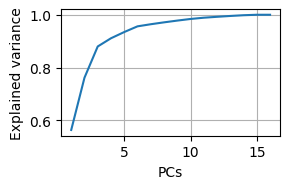

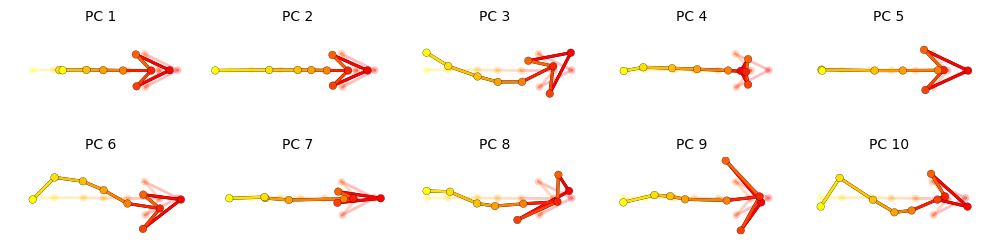

In [22]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

In [23]:
kpms.update_config(project_dir, latent_dim=4)

In [18]:
model = kpms.init_model(data, pca=pca, **config())

Outputs will be saved to
/home/nj35/MRes/moseq_project/EPM_model/2025_04_21-16_49_46


 49%|█████████████████▏                 | 25/51 [02:06<02:08,  4.95s/it]

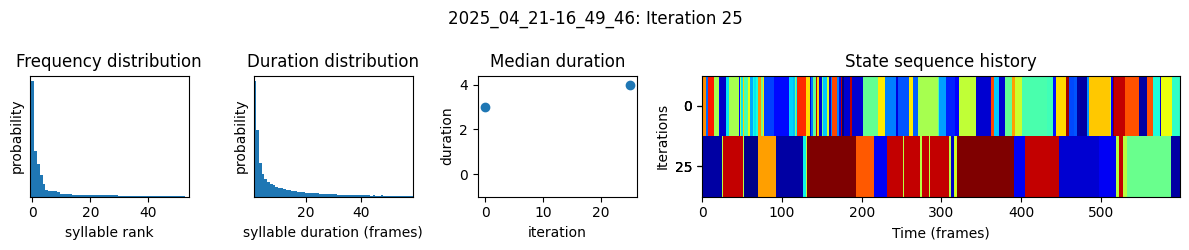

 98%|██████████████████████████████████▎| 50/51 [04:10<00:04,  4.96s/it]

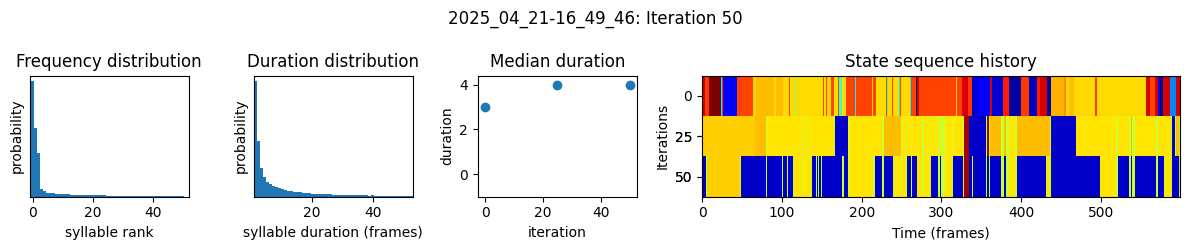

100%|███████████████████████████████████| 51/51 [04:16<00:00,  5.03s/it]


In [19]:
# optionally modify kappa
model = kpms.update_hypparams(model, kappa=5e6) #originally 1e4 for 20 median frames at 50 fps = 400ms syllable duration. 2e4 is 800ms?

num_ar_iters = 50

model, model_name = kpms.fit_model( #you can change model_name for AR-HMM which links to full model
    model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters)


#20 median frames at 50 fps = 400ms / 4 median frames at 50 fps = 80ms?

In [7]:
# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name="model_5e6_5e4")

Outputs will be saved to
/home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4


  5%|█▌                              | 25/501 [05:00<1:28:37, 11.17s/it]

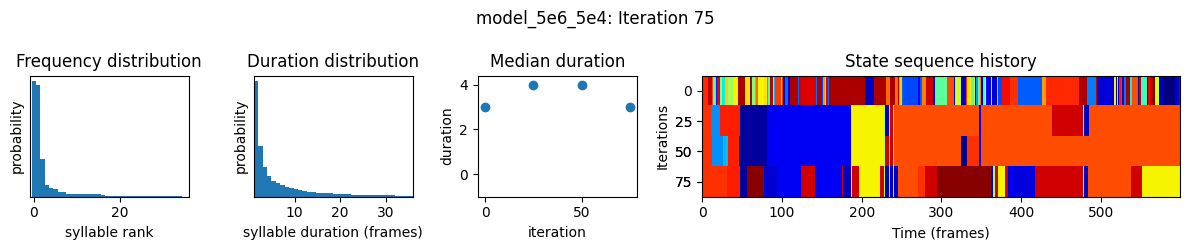

 10%|███▏                            | 50/501 [09:39<1:23:37, 11.13s/it]

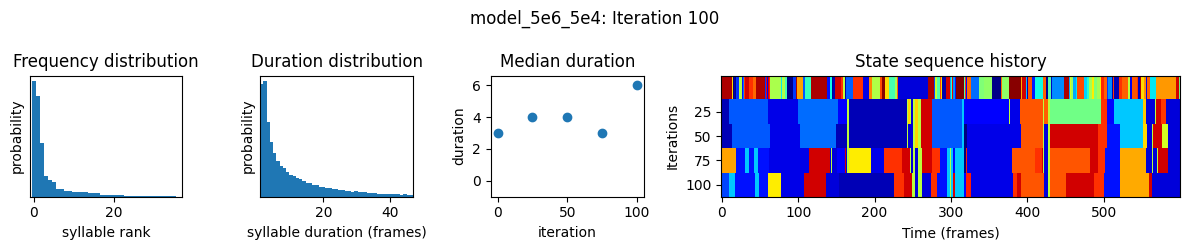

 15%|████▊                           | 75/501 [14:18<1:18:57, 11.12s/it]

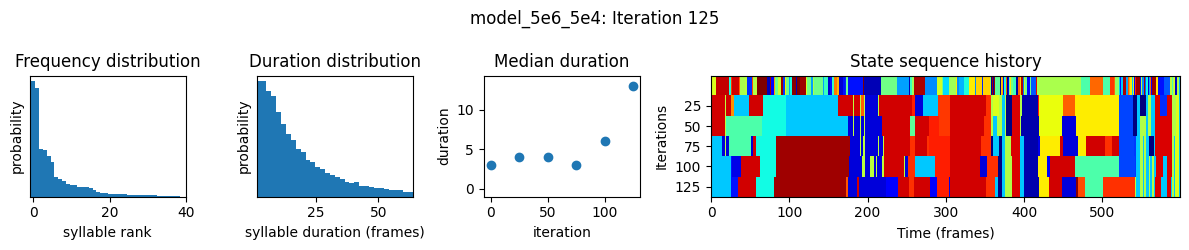

 20%|██████▏                        | 100/501 [18:58<1:14:25, 11.14s/it]

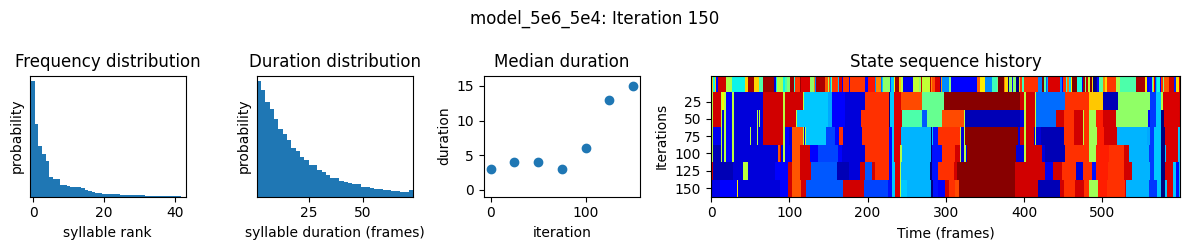

 25%|███████▋                       | 125/501 [23:37<1:09:46, 11.13s/it]

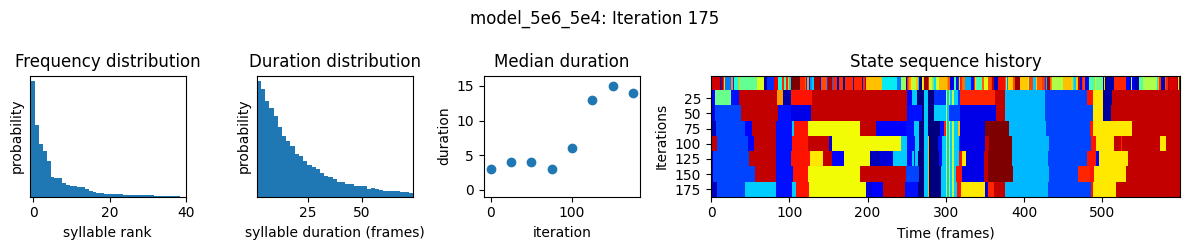

 30%|█████████▎                     | 150/501 [28:16<1:05:07, 11.13s/it]

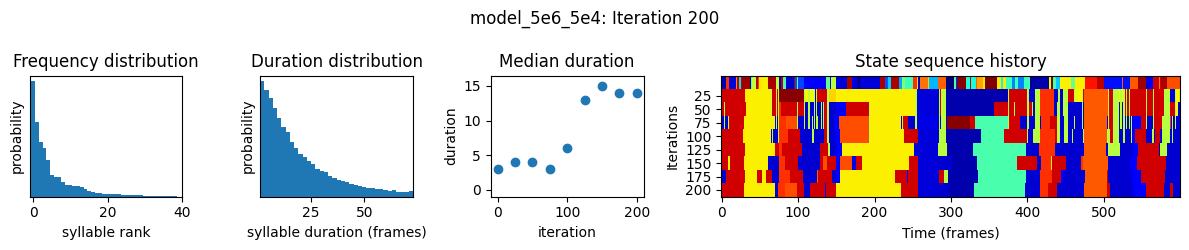

 35%|██████████▊                    | 175/501 [32:55<1:00:24, 11.12s/it]

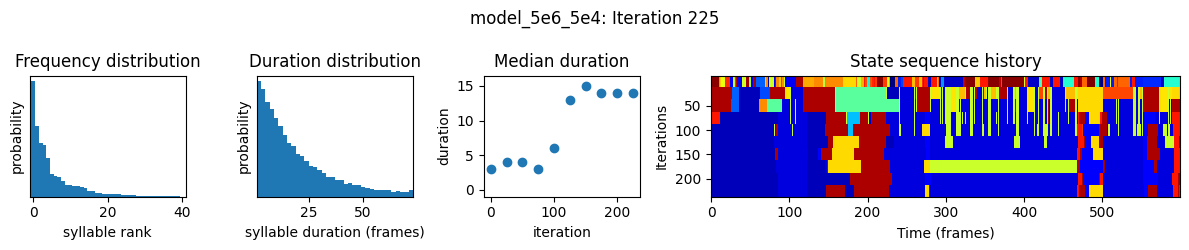

 40%|█████████████▏                   | 200/501 [37:35<55:53, 11.14s/it]

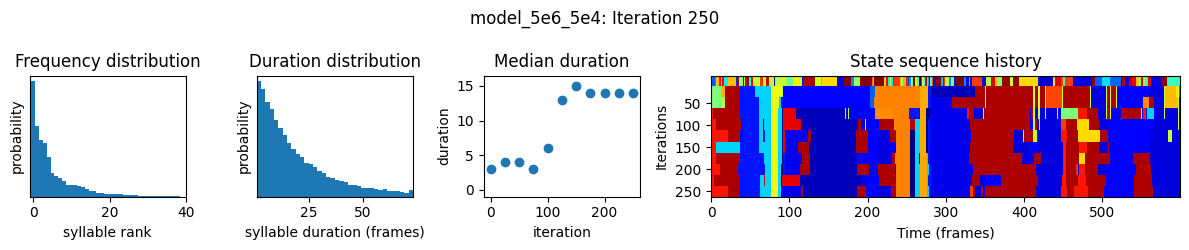

 45%|██████████████▊                  | 225/501 [42:14<51:11, 11.13s/it]

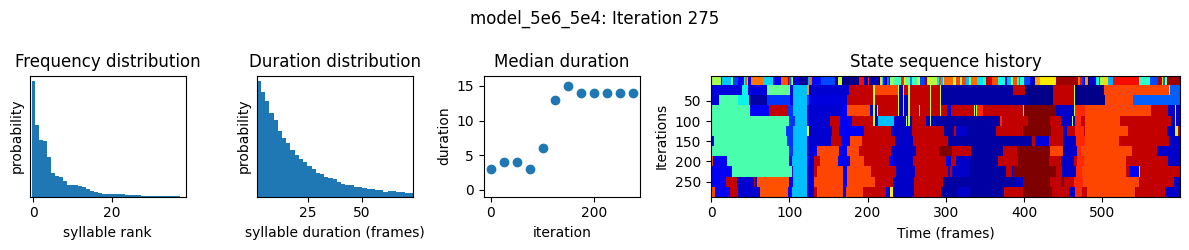

 50%|████████████████▍                | 250/501 [46:53<46:29, 11.11s/it]

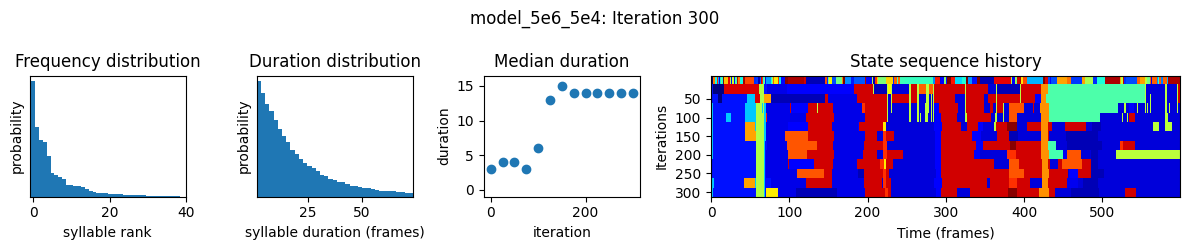

 55%|██████████████████               | 275/501 [51:32<41:56, 11.14s/it]

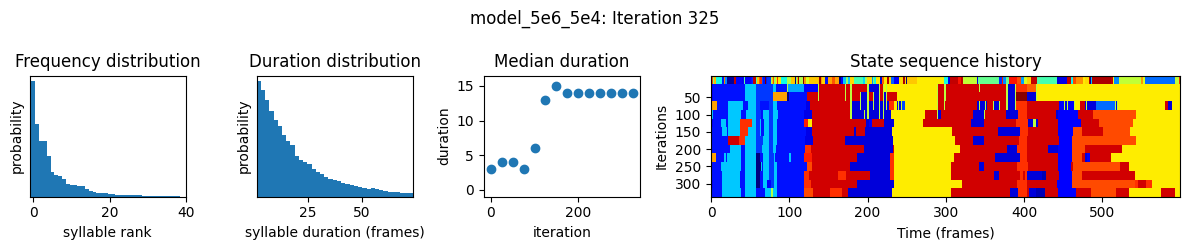

 60%|███████████████████▊             | 300/501 [56:12<37:18, 11.14s/it]

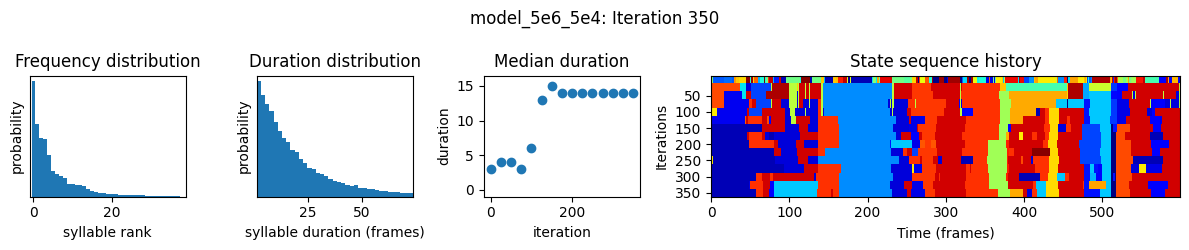

 65%|████████████████████           | 325/501 [1:00:51<32:37, 11.12s/it]

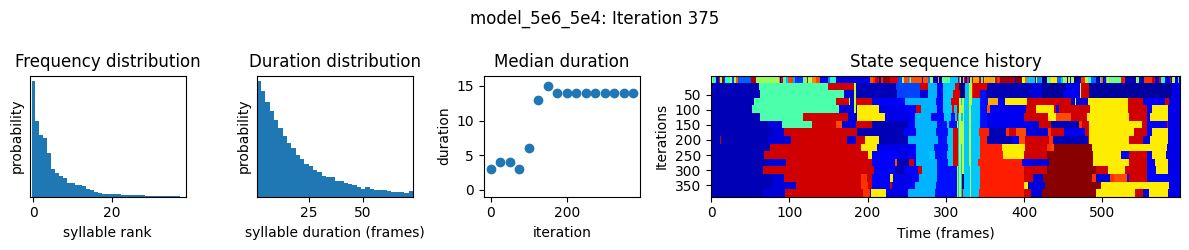

 70%|█████████████████████▋         | 350/501 [1:05:30<28:00, 11.13s/it]

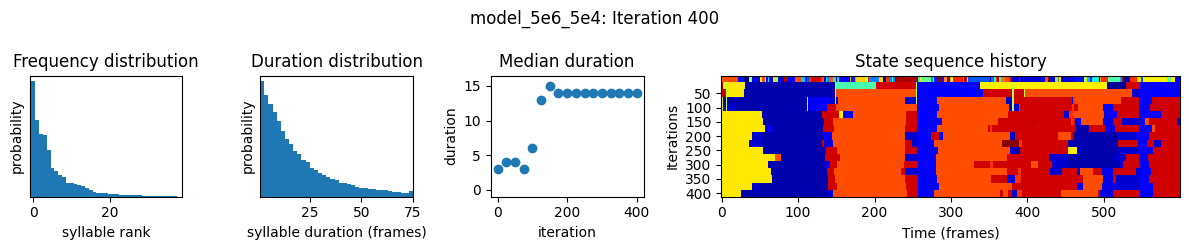

 75%|███████████████████████▏       | 375/501 [1:10:10<23:23, 11.14s/it]

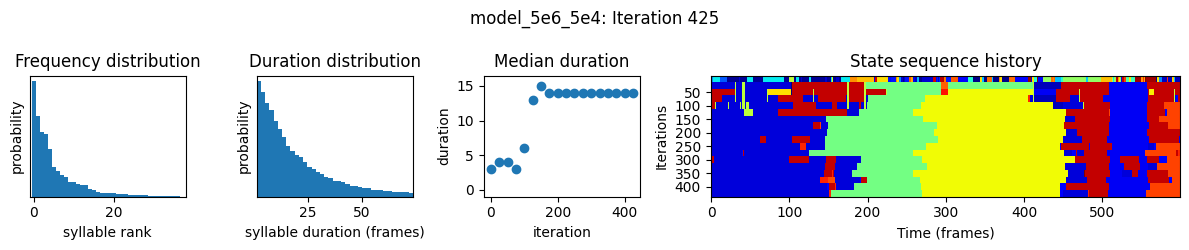

 80%|████████████████████████▊      | 400/501 [1:14:49<18:42, 11.11s/it]

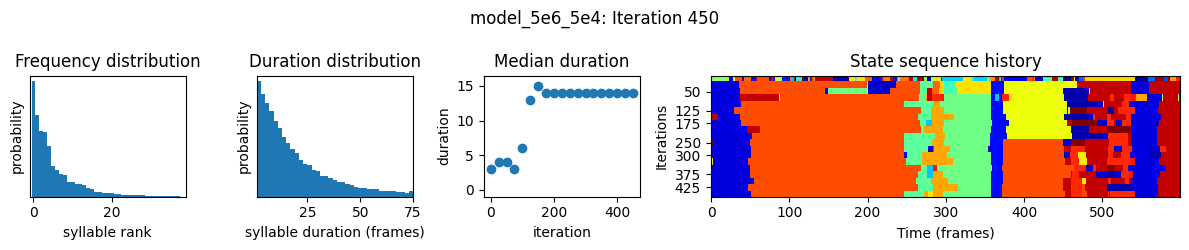

 85%|██████████████████████████▎    | 425/501 [1:19:28<14:05, 11.12s/it]

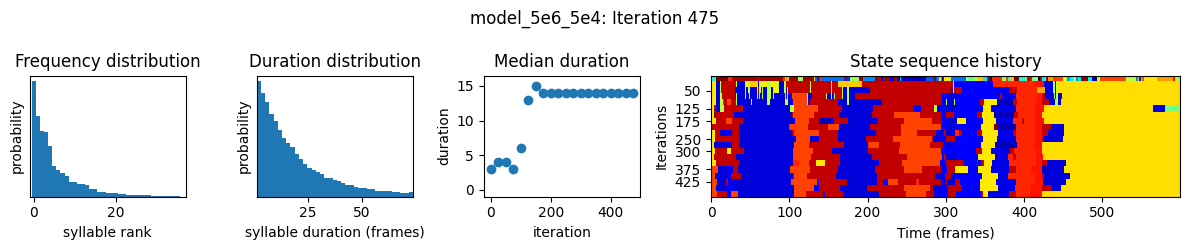

 90%|███████████████████████████▊   | 450/501 [1:24:07<09:28, 11.14s/it]

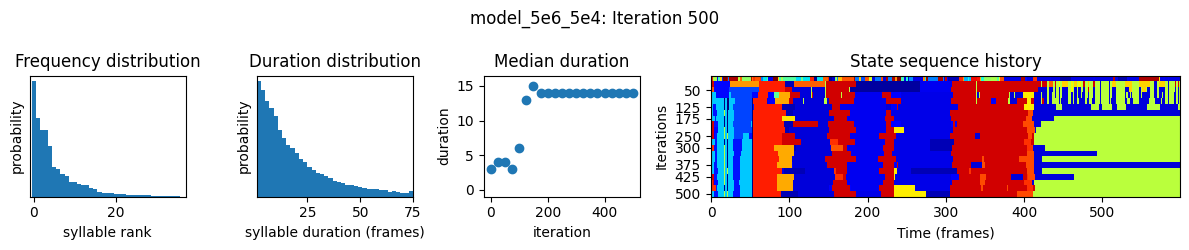

 95%|█████████████████████████████▍ | 475/501 [1:28:47<04:49, 11.15s/it]

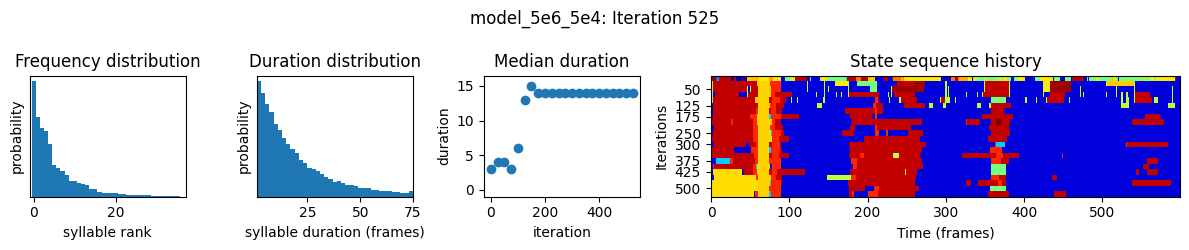

100%|██████████████████████████████▉| 500/501 [1:33:26<00:11, 11.14s/it]

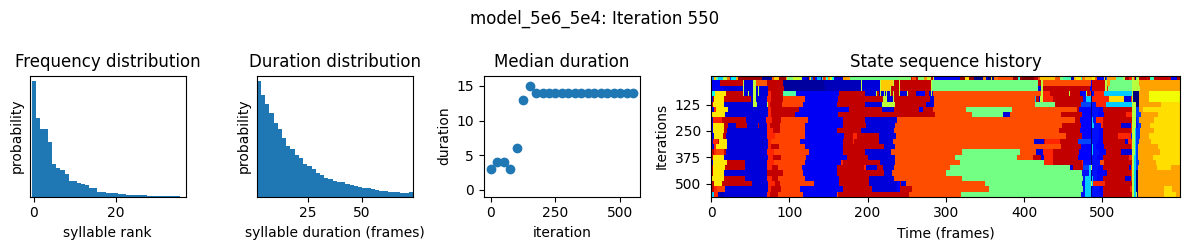

100%|███████████████████████████████| 501/501 [1:33:39<00:00, 11.22s/it]


In [21]:
# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=5e4)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name="model_5e6_5e4", ar_only=False, #2e4 in this line refers to AR-HMM model
    start_iter=current_iter, num_iters=current_iter+500)[0]

In [22]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name="model_5e6_5e4");

Reindexing: 100%|███████████| 23/23 [00:06<00:00,  3.36model snapshot/s]


In [24]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name="model_5e6_5e4")

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name="model_5e6_5e4")

Saved results to
/home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4/results.h5


Saving trajectory plots to /home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4/trajectory_plots


Generating trajectory plots: 100%|██████| 21/21 [00:08<00:00,  2.58it/s]


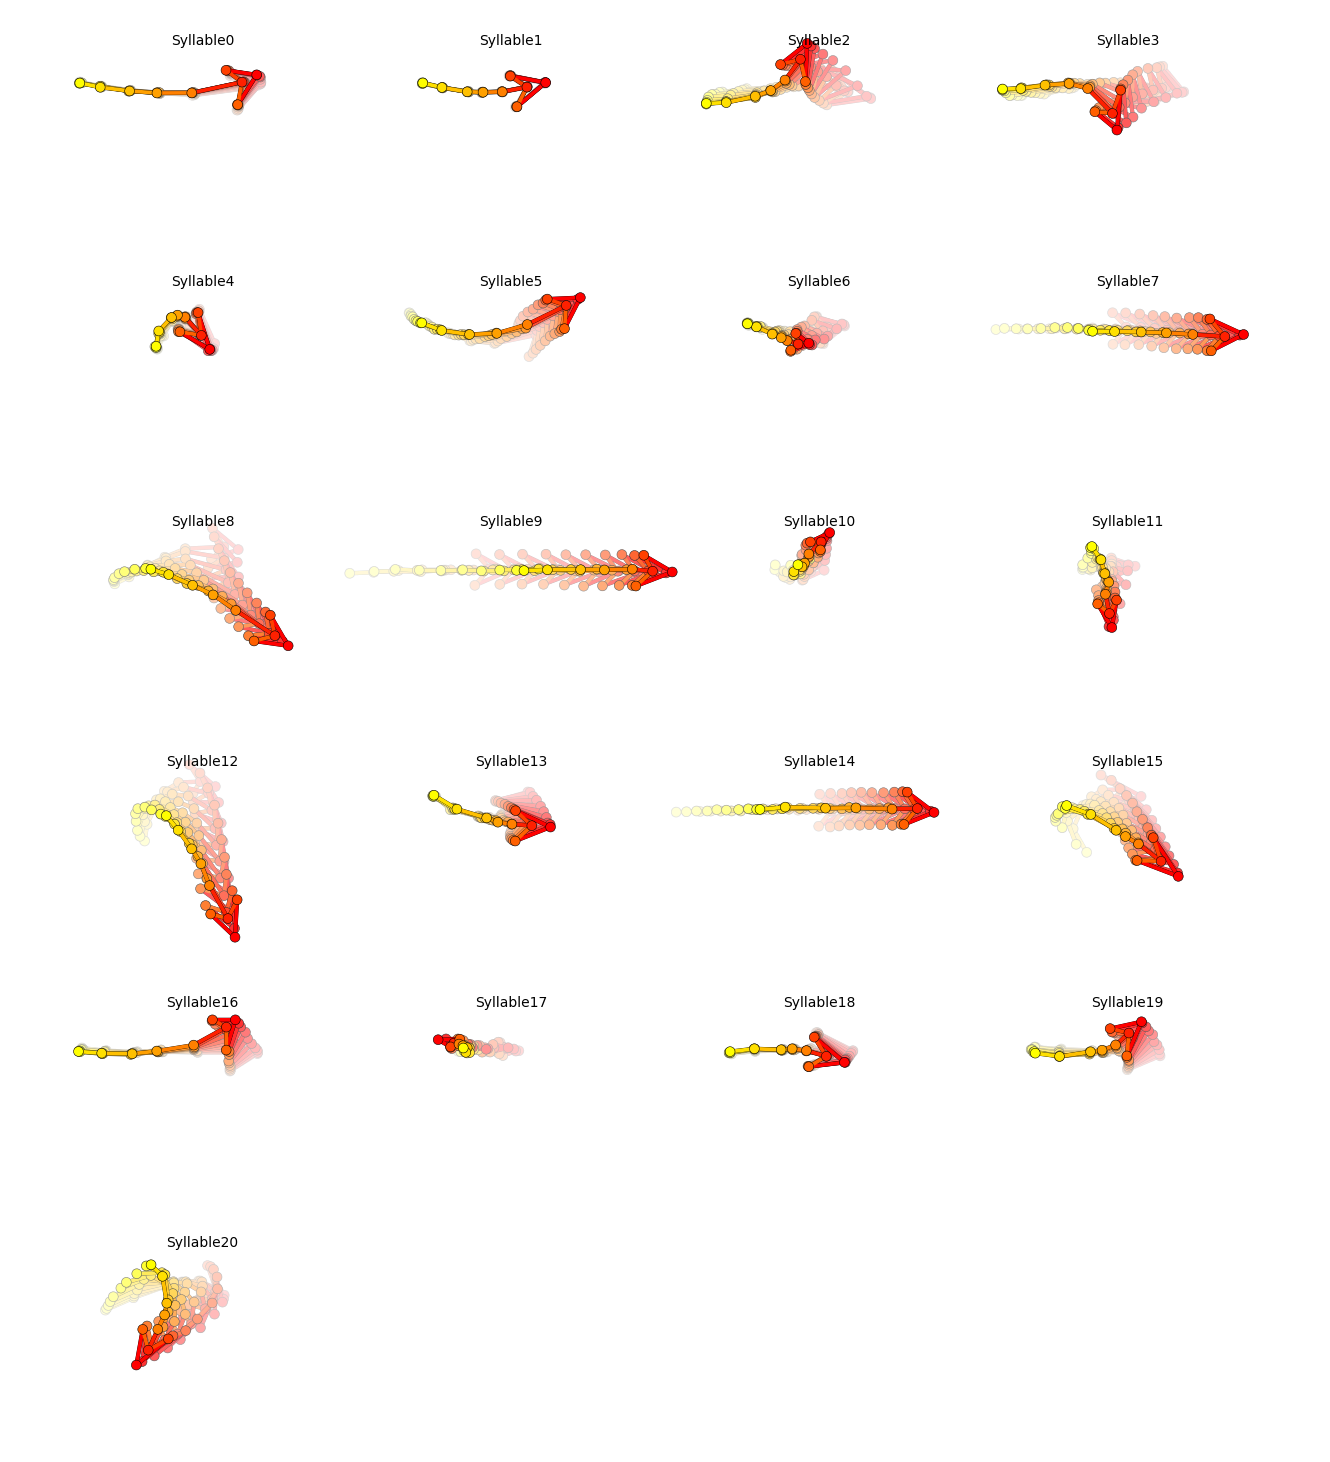

In [25]:
results = kpms.load_results(project_dir, model_name="model_5e6_5e4")
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name="model_5e6_5e4",  density_sample=True, **config())

In [26]:
kpms.generate_grid_movies(
    results, 
    project_dir, 
    model_name="model_5e6_5e4", 
    coordinates=coordinates, 
    pre=50, 
    post=100, 
    **config()
);

Writing grid movies to /home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4/grid_movies


/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/keypoint_moseq/viz.py:1282: UserWarning:


Videos will be downscaled by a factor of 0.95 so that the grid movies
are under 1920 pixels. Use `max_video_size` to increase or decrease
this size limit.





Using window size of 336 pixels


Generating grid movies: 100%|███████████| 21/21 [05:49<00:00, 16.65s/it]


Saving dendrogram plot to /home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4/similarity_dendrogram


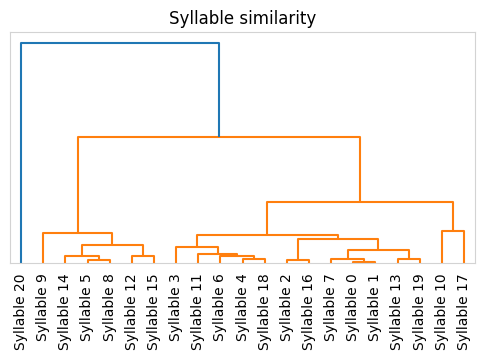

In [27]:
# Plot a dendrogram representing distances between each syllable’s median trajectory.
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name="model_5e6_5e4", **config())

In [12]:
kpms.interactive_group_setting(project_dir, model_name="model_5e6_5e4")

Row
    [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'name': 'recording name',...}, value=              ..., widths={'name': 400})
    [1] Column
        [0] Button(button_type='primary', name='Save group info')

In [28]:
moseq_EPM = kpms.compute_moseq_df(project_dir, model_name="model_5e6_5e4", fps=50, smooth_heading=True) 
moseq_EPM

name  centroid_x  \
0        post-induction-w1_EPM_fixed_1_superanimal_topv...  796.927008   
1        post-induction-w1_EPM_fixed_1_superanimal_topv...  799.551734   
2        post-induction-w1_EPM_fixed_1_superanimal_topv...  799.805738   
3        post-induction-w1_EPM_fixed_1_superanimal_topv...  800.194379   
4        post-induction-w1_EPM_fixed_1_superanimal_topv...  798.913093   
...                                                    ...         ...   
1078882  pre-induction_EPM_trial_4_superanimal_topviewm...  665.575343   
1078883  pre-induction_EPM_trial_4_superanimal_topviewm...  662.684197   
1078884  pre-induction_EPM_trial_4_superanimal_topviewm...  658.625010   
1078885  pre-induction_EPM_trial_4_superanimal_topviewm...  654.899337   
1078886  pre-induction_EPM_trial_4_superanimal_topviewm...  653.077780   

         centroid_y   heading  angular_velocity  velocity_px_s  syllable  \
0        587.273629 -1.830507          0.000000       0.000000         4   
1        584.469527 -1.830507         -0.022872     192.042780         4   
2        582.071459 -1.830507         -0.037085     120.574152         4   
3        582.000491 -1.841909         -0.036311      19.753385         4   
4        583.104406 -1.841909         -0.018220      84.562433         4   
...             ...       ...               ...            ...       ...   
1078882  598.127602  0.062245         -1.341243     152.034783         2   
1078883  597.519904  0.006911         -1.295159     147.716121         2   
1078884  596.641102 -0.055612         -1.114326     207.661336         2   
1078885  594.660382 -0.055548         -0.814468     210.973297         2   
1078886  594.132481 -0.055396         -0.429116      94.825498         2   

         frame_index    group  onset  
0                  0  post_w1   True  
1                  1  post_w1  False  
2                  2  post_w1  False  
3                  3  post_w1  False  
4                  4  post_w1  False  
...              ...      ...    ...  
1078882        30028  control  False  
1078883        30029  control  False  
1078884        30030  control  False  
1078885        30031  control  False  
1078886        30032  control  False  

[1078887 rows x 10 columns]

In [30]:
# summary statistics for each syllable in each recording session, 
# such as its usage frequency and its distribution of kinematic parameters.

model_name='model_5e6_5e4'

moseq_EPM_stats = kpms.compute_stats_df(
    project_dir,
    'model_5e6_5e4',
    moseq_EPM, #change to df created in step before
    groupby=['group', 'name'],
    min_frequency=0.005, # threshold frequency for including a syllable in the dataframe# column(s) to group the dataframe by
    fps=50) # frame rate of the video from which keypoints were inferred                    

moseq_EPM_stats

group                                               name  syllable  \
0    control  pre-induction_EPM_fixed_1_superanimal_topviewm...         0   
1    control  pre-induction_EPM_fixed_1_superanimal_topviewm...         1   
2    control  pre-induction_EPM_fixed_1_superanimal_topviewm...         2   
3    control  pre-induction_EPM_fixed_1_superanimal_topviewm...         3   
4    control  pre-induction_EPM_fixed_1_superanimal_topviewm...         4   
..       ...                                                ...       ...   
744  post_w2  post_w2_EPM_trial_1_(cohort_2)_superanimal_top...        16   
745  post_w2  post_w2_EPM_trial_1_(cohort_2)_superanimal_top...        17   
746  post_w2  post_w2_EPM_trial_1_(cohort_2)_superanimal_top...        18   
747  post_w2  post_w2_EPM_trial_1_(cohort_2)_superanimal_top...        19   
748  post_w2  post_w2_EPM_trial_1_(cohort_2)_superanimal_top...        20   

     heading_mean  heading_std  heading_min  heading_max  \
0       -0.243676     1.549169    -3.140738     3.131405   
1       -0.374944     1.628077    -3.141052     3.138817   
2       -0.347007     1.568331    -3.121435     3.131447   
3       -0.172155     1.710757    -3.129754     3.136265   
4       -0.537993     1.777391    -3.138026     3.139998   
..            ...          ...          ...          ...   
744     -0.543764     2.097650    -3.138135     3.135773   
745     -0.687982     1.730722    -2.978451     3.098223   
746     -0.996153     0.334860    -1.679766    -0.243624   
747      0.998786     1.393042    -1.271412     2.363386   
748     -0.758936     2.212604    -3.140190     3.136329   

     angular_velocity_mean  angular_velocity_std  angular_velocity_min  \
0                 0.099225              6.134802             -4.399756   
1                 0.060932              5.055643             -3.284487   
2                -0.335163             13.158444             -9.106899   
3                 0.048555             16.292070           -313.017001   
4                -0.568294             12.908237           -313.633006   
..                     ...                   ...                   ...   
744               1.339337             25.218974             -3.346174   
745               0.703734             61.711457           -308.667633   
746              -0.030890              0.502854             -1.085131   
747              -0.379200              0.682325             -5.621273   
748             -10.078017             66.198472           -310.727516   

     angular_velocity_max  velocity_px_s_mean  velocity_px_s_std  \
0              313.605404           58.337949          49.345187   
1              314.059031           39.912462          25.654623   
2              313.482792           94.447580          66.726475   
3                7.334053           91.821238          64.043822   
4               31.183200           54.236635          37.880513   
..                    ...                 ...                ...   
744            313.991483           76.201937          41.245770   
745            307.830604          112.934204          63.829991   
746              1.872113           53.846528          31.653447   
747              1.467762          136.996568         132.298234   
748              9.976977          149.908726          93.902075   

     velocity_px_s_min  velocity_px_s_max  frequency  duration  
0             1.136614         477.900577   0.183399  0.452328  
1             0.189726         319.192798   0.176285  0.692825  
2             1.512304         493.745418   0.121739  0.222597  
3             0.561852         433.128644   0.118577  0.247067  
4             0.000000         249.279256   0.060870  0.311169  
..                 ...                ...        ...       ...  
744           2.320595         200.194329   0.007342  0.926000  
745           4.771576         330.464864   0.005874  0.127500  
746           2.537639         206.980041   0.002203  1.406667  
747  

In [31]:
# optional
#save moseq dataframe
save_dir0 = '/home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4'
moseq_EPM.to_csv('/home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4/moseq_EPM.csv', index=False)
print('Saved `moseq_EPM` dataframe to', save_dir0)

Saved `moseq_EPM` dataframe to /home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4


In [32]:
#save moseq stats_df
save_dir1 = '/home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4'
moseq_EPM_stats.to_csv('/home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4/moseq_EPM_stats.csv', index=False)
print('Saved `moseq_EPM_stats` dataframe to', save_dir1)

Saved `moseq_EPM_stats` dataframe to /home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4


In [17]:
kpms.label_syllables(project_dir, model_name= "model_5e6_5e4", moseq_df=moseq_EPM)

Row
    [0] Column
        [0] Select(options=[0, 1, 2, 3, 4, ...], value=0)
        [1] ParamFunction(function, _pane=Video)
    [1] Column
        [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'syllable': 'syllable', ...}, value=    syllable l..., widths={'syllable': 100})
        [1] Column
            [0] Button(button_type='primary', name='Save syllable info')

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



No significant syllables found.
No significant syllables found.
No significant syllables found.
Saved figure to /home/nj35/MRes/moseq_project/EPM_model/model_5e6_5e4/figures/frequency_stat_stats.png


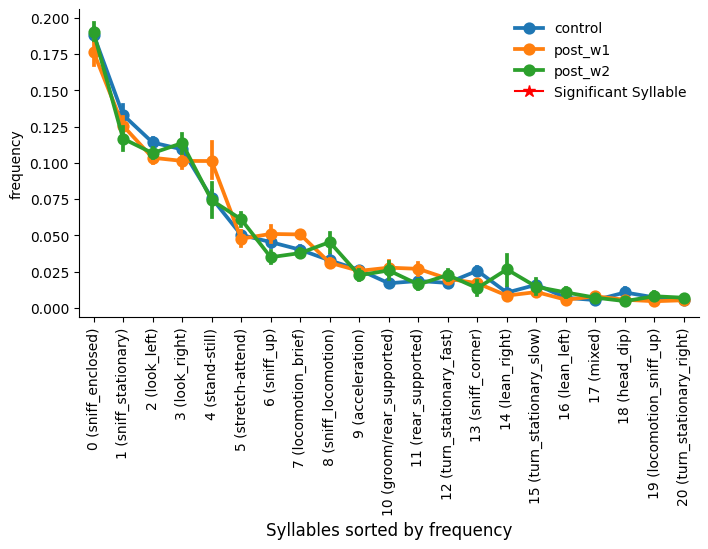

In [17]:
model_name="model_5e6_5e4"

kpms.plot_syll_stats_with_sem(
    moseq_EPM_stats,
    project_dir,
    model_name,
    plot_sig=True,  # whether to mark statistical significance with a star
    thresh=0.05,  # significance threshold
    stat="frequency",  # statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order="stat",  # order syllables by overall frequency ("stat") or degree of difference ("diff")
    #ctrl_group="a",  # name of the control group for statistical testing
    #exp_group="b",  # name of the experimental group for statistical testing
    figsize=(8, 4),  # figure size
    groups=moseq_EPM_stats["group"].unique(),  # groups to be plotted
);